In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# LSFF: Data gap filling with naive estimation


In [2]:
## load legal combos
import pickle
data_prep_dir = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/inputs/'

with open(data_prep_dir + 'lsff_vehicle_nutrient_pairs.pickle', 'rb') as handle:
    vehicle_nutrient_map = pickle.load(handle)
    
with open(data_prep_dir + 'lsff_country_vehicle_pairs.pickle', 'rb') as handle:
    country_vehicle_map = pickle.load(handle)
    
with open(data_prep_dir + 'lsff_vehicle_country_pairs.pickle', 'rb') as handle:
    vehicle_country_map = pickle.load(handle)

In [3]:
summary_path = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/outputs/data_counts_full.csv'
summary = pd.read_csv(summary_path)

## divide into value_descriptions to which the nutrient col is /isn't relevant

nutr_a = summary[summary.nutrient!='na']
nutr_na = summary[summary.nutrient=='na']

nutr_a = pd.pivot_table(nutr_a, index = ['location_name','vehicle','nutrient'], columns = 'value_description', values = 'mean_mean', dropna=False).reset_index()
nutr_na = pd.pivot_table(nutr_na, index = ['location_name','vehicle'], columns = 'value_description',values = 'mean_mean', dropna=False).reset_index()
df = nutr_a.merge(nutr_na, on = ['location_name','vehicle'], how = 'outer')

In [4]:
## filter back down to applicable variables

country_veh_filter = [v in country_vehicle_map[c] for (v,c) in zip(df.vehicle,df.location_name)]
vehicle_nutr_filter = [n in vehicle_nutrient_map[v] for (n,v) in zip(df.nutrient,df.vehicle)]

df = df[[x and y for (x,y) in zip(country_veh_filter,vehicle_nutr_filter)]]

In [5]:
value_d_codes = {'percent of population eating vehicle': 'A',
                 'percent of population eating industrially produced vehicle': 'B',
                 'percent of population eating fortified vehicle': 'C',
                 'percent of vehicle that is industrially produced': 'D',
                 'percent of vehicle that is fortified': 'E',
                 'percent of market covered by fortified product': 'F'}
df = df.rename(columns=value_d_codes)[['location_name','vehicle','nutrient','A','B','C','D','E','F']]

In [6]:
df.head()

value_description,location_name,vehicle,nutrient,A,B,C,D,E,F
7,Angola,maize flour,folic acid,NaN,NaN,NaN,0.0,NaN,NaN
8,Angola,maize flour,iron,NaN,NaN,NaN,0.0,NaN,NaN
9,Angola,maize flour,vitamin a,NaN,NaN,NaN,0.0,NaN,NaN
10,Angola,maize flour,vitamin b1,NaN,NaN,NaN,0.0,NaN,NaN
11,Angola,maize flour,vitamin b12,NaN,NaN,NaN,0.0,NaN,NaN


In [7]:
# A : "percent of population eating vehicle"
# B : "percent of population eating industrially produced vehicle"
# C : "percent of population eating fortified vehicle"

# D : "percent of vehicle that is industrially produced"
# E : "percent of vehicle that is fortified"

# C_0 : guess of "percent of population eating fortified vehicle" based on a
#       lack of evidence in the GFDx and data on other nutrient for the same loc-veh pair
# E_0 : guess of percent of vehicle that is fortified, based on a lack of evidence in the GFDx
#       and data on other nutrient for the same loc-veh pair

# B_1: percent of pop eating vehicle * percent of vehicle that is industrially prod = A * D

# C_1 : percent of population eating vehicle * percent of vehicle that is fortified = A * E
# C_1_0: percent of population eating vehicle * guess of percent of vehicle that is fortified = A * E_0

# C_2 : percent of population eating industrially produced vehicle * percent of vehicle that is fortified = B * E
# C_2_0: percent of population eating ind prod vehicle * guess of percent of vehicle that is fortified = B * E_0

# C_3 : percent of population eating vehicle * percent of vehicle that is industrially prod
#                                           * percent of vehicle that is fortified = A * D * E
# C_3_0 : percent of population eating vehicle * percent of vehicle that is industrially prod
#                                           * guess of percent of vehicle that is fortified = A * D * E_0

In [8]:
# run diagnostics on these and then choose or average some. always perfer A/B/C to estimates.

In [9]:
def pull_fort_legislation():
    fort_legislation_path = '/snfs1/Project/simulation_science/lsff/01_LSFF_GBD_2019/fortification_legislation_data.csv'
    df = pd.read_csv(fort_legislation_path, encoding = 'iso-8859-1')

    nutrient_rename = {i:i.lower() for i in df.Micronutrient.unique()}
    vehicle_rename = {i:i.lower() for i in df.Vehicle.unique()}
    loc_rename = {'Cote d\x92Ivoire':"Côte d'Ivoire", 'Tanzania':"United Republic of Tanzania", 'Viet Nam':"Vietnam"}

    df['nutrient'] = df.Micronutrient.map(nutrient_rename)
    df['vehicle'] = df.Vehicle.map(vehicle_rename)
    df['location_name'] = df.Country
    df.loc[df.location_name.isin(loc_rename.keys()),'location_name'] = df.location_name.map(loc_rename)
    df.rename(columns={'Standard':'standard'}, inplace=True)

    return df[['location_name','vehicle','nutrient','standard']]

fort_legislation = pull_fort_legislation()

In [10]:
df = fort_legislation.merge(df, on = ['location_name','vehicle','nutrient'], how = 'right')

In [11]:
## make sure all tuples are still valid

country_veh_filter = [v in country_vehicle_map[c] for (v,c) in zip(df.vehicle,df.location_name)]
vehicle_nutr_filter = [n in vehicle_nutrient_map[v] for (n,v) in zip(df.nutrient,df.vehicle)]

assert(len(df[[not (x and y) for (x,y) in zip(country_veh_filter,vehicle_nutr_filter)]])==0)

In [12]:
df.standard.unique()

array(['Unknown', nan, 'Mandatory', 'Voluntary', 'None',
       'Mandatory in Punjab only'], dtype=object)

In [13]:
# if not mandatory, we'll guess pct fortified = 0
df.loc[(df.standard!='Mandatory'),'C_0'] = 0
df.loc[(df.standard!='Mandatory'),'E_0'] = 0

In [14]:
#for each location
    #for each vehicle
        #for a nutrient_i:
            #if the GFDx has evidence of mandatory loc-veh-nutrient_i fortification
                #if we don't have data for loc-veh-nutrient_i
                    #if we do have data for loc-veh-{nutrient_j,k,...,n}:
                        # assign mean(loc-veh-{nutrient_j,k,...,n}) to nutrient_i

In [15]:
count_c, count_e = 0, 0
for loc in df.location_name.unique():
    for v in country_vehicle_map[loc]:
        for n in vehicle_nutrient_map[v]:
#             if there is evidence of Mandatory fortification for this tuple
            if df.loc[(df.location_name==loc) &
                      (df.vehicle==v) &
                      (df.nutrient==n) &
                      (df.standard=="Mandatory")].shape[0]>0:
                mean_C = df.loc[(df.location_name==loc) &
                      (df.vehicle==v) &
                      (df.nutrient==n) &
                        (df.standard=="Mandatory"),'C'].mean()
                mean_E = df.loc[(df.location_name==loc) &
                      (df.vehicle==v) &
                      (df.nutrient==n) &
                        (df.standard=="Mandatory"),'E'].mean()
                if not np.isnan(mean_C):
                    count_c += 1
                    df.loc[(df.location_name==loc) &
                      (df.vehicle==v) &
                      (df.nutrient==n) &
                      (df.standard=="Mandatory"),'C_0'] = mean_C
                if not np.isnan(mean_E):
                    count_e += 1
                    df.loc[(df.location_name==loc) &
                      (df.vehicle==v) &
                      (df.nutrient==n) &
                      (df.standard=="Mandatory"),'E_0'] = mean_E

In [16]:
count_c, count_e

(55, 79)

In [17]:
# A : "percent of population eating vehicle"
# B : "percent of population eating industrially produced vehicle"
# C : "percent of population eating fortified vehicle"

# D : "percent of vehicle that is industrially produced"
# E : "percent of vehicle that is fortified"

# C_0 : guess of "percent of population eating fortified vehicle" based on a
#       lack of evidence in the GFDx and data on other nutrient for the same loc-veh pair
# E_0 : guess of percent of vehicle that is fortified, based on a lack of evidence in the GFDx
#       and data on other nutrient for the same loc-veh pair

# B_1: percent of pop eating vehicle * percent of vehicle that is industrially prod = A * D

# C_1 : percent of population eating vehicle * percent of vehicle that is fortified = A * E
# C_1_0: percent of population eating vehicle * guess of percent of vehicle that is fortified = A * E_0

# C_2 : percent of population eating industrially produced vehicle * percent of vehicle that is fortified = B * E
# C_2_0: percent of population eating ind prod vehicle * guess of percent of vehicle that is fortified = B * E_0

# C_3 : percent of population eating vehicle * percent of vehicle that is industrially prod
#                                           * percent of vehicle that is fortified = A * D * E
# C_3_0 : percent of population eating vehicle * percent of vehicle that is industrially prod
#                                           * guess of percent of vehicle that is fortified = A * D * E_0

In [18]:
df.loc[(df.A.notna()) & (df.D.notna()),'B_1'] = df.A * df.D *.01

df.loc[(df.A.notna()) & (df.E.notna()),'C_1'] = df.A * df.E *.01
df.loc[(df.A.notna()) & (df.E_0.notna()),'C_1_0'] = df.A * df.E_0 *.01

df.loc[(df.B.notna()) & (df.E.notna()),'C_2'] = df.B * df.E *.01
df.loc[(df.B.notna()) & (df.E_0.notna()),'C_2_0'] = df.B * df.E_0 *.01

df.loc[(df.A.notna()) & (df.D.notna()) & (df.E_0.notna()),'C_3'] = df.A * df.D * df.E_0 * .0001
df.loc[(df.A.notna()) & (df.D.notna()) & (df.E_0.notna()),'C_3_0'] = df.A * df.D * df.E_0 * .0001

In [19]:
def abs_error(df, x):
    ref = x[6:7]
    est = x[6:]
    df.loc[(df[ref].notna()) & (df[est].notna()),x] = np.abs(df[ref] - df[est])
    return df


errors = [f'error_{i}' for i in ['B_1','C_1','C_1_0','C_2','C_2_0','C_3','C_3_0']]

for x in errors:
    df = abs_error(df, x)

In [20]:
df[errors].describe()

,error_B_1,error_C_1,error_C_1_0,error_C_2,error_C_2_0,error_C_3,error_C_3_0
count,107.000000,22.000000,36.000000,20.000000,34.000000,25.000000,25.000000
mean,18.494926,24.379844,16.730053,14.311700,10.223333,5.882613,5.882613
std,22.058740,19.585054,18.772061,13.607736,12.661566,6.032217,6.032217
min,0.000000,2.650000,0.000000,2.650000,0.000000,0.000000,0.000000
25%,2.455833,4.636000,2.125000,3.786500,1.375000,2.500000,2.500000
50%,9.733333,30.870000,6.172000,6.158000,4.387667,5.333333,5.333333
75%,24.187500,34.770000,30.870000,30.790000,21.209500,6.300000,6.300000
max,92.765000,62.394583,62.394583,37.320000,37.320000,27.800000,27.800000


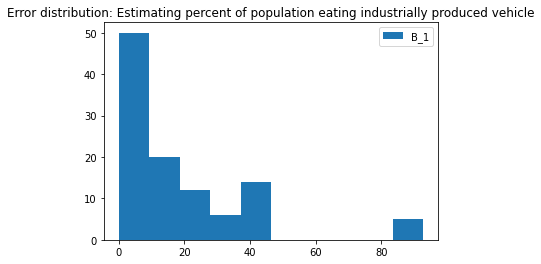

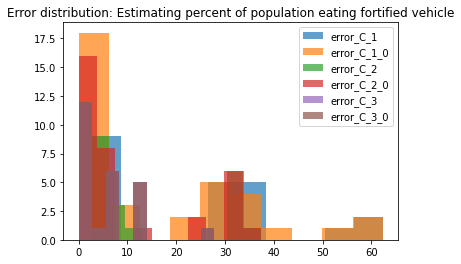

In [21]:
plt.title('Error distribution: Estimating percent of population eating industrially produced vehicle')
plt.hist(df.error_B_1, label = "B_1")
plt.legend()
plt.show()

plt.title('Error distribution: Estimating percent of population eating fortified vehicle')
for x in errors[1:]:
    plt.hist(df[x], alpha = 0.7, label = x)
    
plt.legend()
plt.show()

In [22]:
def checkout_metrics(df, x):
    out = pd.DataFrame({
        'col':[x],
        'error_rate':[df[x].sum() / len(df[x].notna())],
        'sample_size':[sum(df[x].notna())],
        'total_relative_error':[df[errors].dropna().sum()[x]],
        'total_absolute_error':[df[x].sum()]
    })
    return out

In [23]:
metrics = pd.concat([checkout_metrics(df, x) for x in errors[1:]])
metrics

,col,error_rate,sample_size,total_relative_error,total_absolute_error
0,error_C_1,1.528081,22,323.818,536.356577
0,error_C_1_0,1.715903,36,328.810,602.281910
0,error_C_2,0.815481,20,236.824,286.234000
0,error_C_2_0,0.990294,34,237.250,347.593333
0,error_C_3,0.418990,25,135.732,147.065333
0,error_C_3_0,0.418990,25,135.732,147.065333


In [24]:
save_path = 'problem_data.csv'

In [25]:
df[(df.A < df.B)].to_csv(save_path, index = False)

In [24]:
c_estimates = ['C_1','C_1_0','C_2','C_2_0','C_3','C_3_0']
df['C_n'] = df[c_estimates].mean(axis=1)

In [25]:
df['A_final'] = df.A

In [26]:
df['B_final'] = [b if pd.notna(b) else b1 for (b,b1) in zip(df.B,df.B_1)]

In [27]:
df['C_final'] = [c if pd.notna(c) else cn for (c,cn) in zip(df.C,df.C_n)]

In [28]:
output = df[['location_name', 'vehicle', 'nutrient', 'standard','A_final','B_final','C_final']]
output.rename(columns = {'A_final':'A',
                        'B_final':'B',
                        'C_final':'C'}, inplace = True)

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [34]:
value_d_codes

{'percent of population eating vehicle': 'A',
 'percent of population eating industrially produced vehicle': 'B',
 'percent of population eating fortified vehicle': 'C',
 'percent of vehicle that is industrially produced': 'D',
 'percent of vehicle that is fortified': 'E',
 'percent of market covered by fortified product': 'F'}

In [29]:
inverse_value_d_codes = {v:k for (k,v) in zip(value_d_codes.keys(),value_d_codes.values())}

output.rename(columns = inverse_value_d_codes, inplace = True)

In [30]:
## make sure all tuples are still valid

country_veh_filter = [v in country_vehicle_map[c] for (v,c) in zip(df.vehicle,df.location_name)]
vehicle_nutr_filter = [n in vehicle_nutrient_map[v] for (n,v) in zip(df.nutrient,df.vehicle)]

assert(len(df[[not (x and y) for (x,y) in zip(country_veh_filter,vehicle_nutr_filter)]])==0)

In [31]:
save_path = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/outputs/lsff_data_estimated.csv'

In [33]:
output.to_csv(save_path, index = False)